In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K

import matplotlib.pyplot as plt

Using Theano backend.
Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [2]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 224*224#img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [3]:
def preprocess_image(image_path):
    img = load_img(image_path)#, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [4]:
# feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']

# output_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

# # print outputs_dict

# loss = K.variable(0.)
# for layer_name in feature_layers:
#     layer_features = output_dict[layer_name]
#     combination_features = layer_features[1, :, :, :]
#     style_features = layer_features[2, :, :, :]
    
#     loss += style_loss(combination_features, style_features) / len(feature_layers)

In [5]:
def get_loss(y_true, y_pred):
#     feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']

#     output_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

#     # print outputs_dict

#     loss = K.variable(0.)
#     for layer_name in feature_layers:
#         layer_features = output_dict[layer_name]
#         combination_features = layer_features[1, :, :, :]
#         style_features = layer_features[2, :, :, :]
#         loss += style_loss(combination_features, style_features) / len(feature_layers)
        
#     return 1
    loss = style_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
    print "loss", K.shape(loss), loss
    return loss

In [46]:
# Combine generative layer with VGG layer
inputs = Input(shape=(224*224*3, ))
    
# Layer 1
x1 = Dense(500, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(16*7*7, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((16, 7, 7))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 14, 14)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 4
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 5
x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) # 28, 28 -> 224, 224
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

vgg_model = VGG16(weights = 'imagenet', include_top = False)
for layer in vgg_model.layers:
    layer.trainable = False
outp_vgg = vgg_model.output

# Discriminative model
disc_model = Model(input = vgg_model.input, output = vgg_model.layers[2].output)

In [47]:
model = Sequential()
model.add(generative_model)
model.add(disc_model)

In [48]:
import keras
# adam_op = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=5, momentum=0.9, nesterov=True)
model.compile(loss = get_loss, optimizer = sgd)

loss Shape.0 Elemwise{true_div,no_inplace}.0


In [49]:
model.fit(np.array(trainX3), np.array(trainY2), nb_epoch = 100)

Epoch 1/100
1/1 [==============================] - 0s - loss: 382.3404
Epoch 2/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 3/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 4/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 5/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 6/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 7/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 8/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 9/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 10/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 11/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 12/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 13/100
1/1 [==============================] - 0s - loss: 38259.6562
Epoch 14/100
1/1 [==============================]

In [41]:
#trainY
jpgfile = Image.open("van.jpg")
inp = np.array(jpgfile.getdata())
inp = np.array(jpgfile.getdata())
inp = inp.swapaxes(0, 1)
inp = np.reshape(inp, (1, 3, 224, 224))
# trainY = disc_model.predict([inp])
trainY2 = disc_model.predict([inp/256])

In [42]:
import Image
jpgfile = Image.open("orig.jpg")
inp = np.array(jpgfile.getdata())
inp = inp.swapaxes(0, 1)
trainX = np.reshape(inp, (1, 3, 224, 224))
# trainX = disc_model.predict([inp])

In [43]:
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))

In [44]:
trainX3 = trainX2/256

In [93]:
trainX.shape

(1, 3, 224, 224)

In [50]:
img = generative_model.predict(trainX3)

In [51]:
img = img[0]
img = img.swapaxes(0, 2).swapaxes(0, 1)

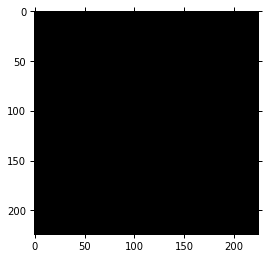

In [52]:
plt.imshow(img*256)
plt.show()

In [53]:
img[0]

array([[[ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        ..., 
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.]],

       [[ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        ..., 
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.]],

       [[ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        ..., 
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.]],

       ..., 
       [[ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        ..., 
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.]],

       [[ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        ..., 
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.]],

       [[ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        ..., 
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,